In [1]:
import gym
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

2023-03-02 01:58:22.369177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 01:58:22.846771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/alirahman/miniconda3/envs/tf/lib/:/home/alirahman/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-03-02 01:58:22.846819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: 

/home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:45: UserWarning: WARN: A Box observation space maximum and minimum values are equal.
  logger.warn("A Box observation space maximum and minimum values are equal.")
/home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment in

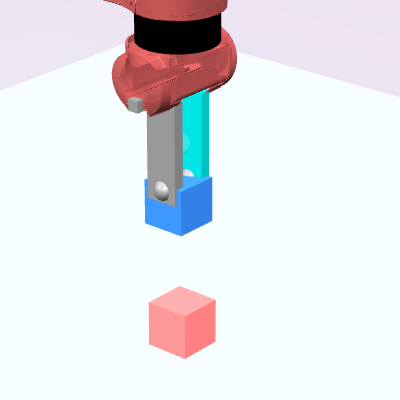

In [2]:
env = gym.make("sawyer:PickPlace-v0", cam_id=0, action_scale=2/100)
env.reset()
env.hide_mocap()
env.reset()
#p = env.action_space.sample()
env.put_obj_in_hand()
img, depth = env.render('rgbd', width=400, height=400)
Image.fromarray(img)

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from collections import deque
import pickle
import matplotlib.pyplot as plt
import time

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Model

from baselines import bench
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
#from baselines.common import plot_util as pu
from baselines.common.vec_env.vec_normalize import VecNormalize as VecNormalize_


class DiagGaussian():
    def __init__(self, mean, logstd):
        self.set_param(mean, logstd)

    def set_param(self, mean, logstd): # Used so that we don't need to make a new DiagGaussian object every time mu and log_sigma changes
        self.mean = mean
        self.logstd = logstd
        self.std = tf.exp(logstd)

    def mode(self):
        return self.mean

    def logp(self, x):
        neg_logp = 0.5 * tf.reduce_sum(tf.square((x - self.mean) / self.std), axis=-1) \
                 + 0.5 * np.log(2.0 * np.pi) * tf.cast(tf.shape(x)[-1], dtype=tf.float32) \
                 + tf.reduce_sum(self.logstd, axis=-1)
        return -tf.expand_dims(neg_logp, axis=-1) # Expand dims to get correct shape

    def entropy(self):
        return tf.expand_dims(tf.reduce_sum(self.logstd + .5 * np.log(2.0 * np.pi * np.e), axis=-1), axis=-1) # Expand dims to get correct shape

    def sample(self):
        return self.mean + self.std * tf.random.normal(tf.shape(self.mean))
    

class VecNormalize(VecNormalize_): 
    def __init__(self, *args, **kwargs):
        super(VecNormalize, self).__init__(*args, **kwargs)
        self.training = True

    def _obfilt(self, obs, update=True):
        if self.ob_rms:
            if self.training and update:
                self.ob_rms.update(obs)
            obs = np.clip((obs - self.ob_rms.mean) /
                          np.sqrt(self.ob_rms.var + self.epsilon),
                          -self.clipob, self.clipob)
            return obs
        else:
            return obs
    
    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        self.ret = self.ret * self.gamma + rews
        obs = self._obfilt(obs)
        if self.ret_rms:
            self.ret_rms.update(self.ret)
            rews = np.clip(rews / np.sqrt(self.ret_rms.var + self.epsilon), -self.cliprew, self.cliprew)
        self.ret[news] = 0.
        return obs[-1], rews[-1], news[-1], infos[-1] # Indexing at -1 since we will only ever have 1 env in wrapper
    
    def reset(self):
        self.ret = np.zeros(self.num_envs)
        obs = self.venv.reset()
        return self._obfilt(obs)[-1] # Indexing at -1 since we will only ever have 1 env in wrapper

    def train(self):
        self.training = True

    def eval(self):
        self.training = False # Prevents ob_rms from updating during testing

# Checks whether done was caused by timit limits or not
class TimeLimitMask(gym.Wrapper):
    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        if done and self.env._max_episode_steps == self.env._elapsed_steps:
            info['bad_transition'] = True

        return obs, rew, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    
    
class Model_Actor_Critic(Model):
    def __init__(self, state_space_dim, action_space_dim,
                 actor_hidden_units, critic_hidden_units):
        super(Model_Actor_Critic, self).__init__()

        self.input_layer = InputLayer(input_shape=(state_space_dim,))
        
        # Actor layers
        self.actor_hidden_layers = []
        for units in actor_hidden_units:
            self.actor_hidden_layers.append(Dense(units=units, activation='relu', kernel_initializer='GlorotNormal'))
        self.mu = Dense(units=action_space_dim, activation='tanh', kernel_initializer='GlorotNormal')
        self.log_sigma = tf.Variable(initial_value=np.zeros(shape=(1, action_space_dim)), dtype=tf.float32) 
        self.trainable_weights.append(self.log_sigma) # Add log_sigma to list of trainable variables for model

        # Critic layers
        self.critic_hidden_layers = []
        for units in critic_hidden_units:
            self.critic_hidden_layers.append(Dense(units=units, activation='relu', kernel_initializer='GlorotNormal'))
        self.values = Dense(units=1, activation=None, kernel_initializer='GlorotNormal')

        self.dist = DiagGaussian(self.mu, self.log_sigma)

    # @tf.function decoration runs function in graph mode - signficantly faster than eager execution in tf 2.0
    @tf.function
    def __call__(self, states):
        states = tf.cast(states, tf.float32) # Single precision required, explict casting in __call__
        x = y = self.input_layer(states)

        for layer in self.actor_hidden_layers:
            x = layer(x)

        for layer in self.critic_hidden_layers:
            y = layer(y)
            
        return self.mu(x), self.values(y)

    def act(self, state):
        mu, value = self(state[np.newaxis, :]) # Add new axis to make tensor the correct shape (batch size, state_dim)
        self.dist.set_param(mu, self.log_sigma)

        action = self.dist.sample()
        action_logp = self.dist.logp(action)
        
        return value[0].numpy(), action[0].numpy(), action_logp[0].numpy()
    
    def evaluate_actions(self, states, actions):
        mu, values = self(states)
        self.dist.set_param(mu, self.log_sigma)

        return values, self.dist.logp(actions), self.dist.entropy()
    
    def get_value(self, state):
        _, value = self(state[np.newaxis, :]) # Add new axis to make tensor the correct shape (batch size, state_dim)

        return value[0].numpy()

    
class PPO_Agent():
    def __init__(self, params, env_name, model_dir, log_dir, plot_dir, seed=0):
        self.params = params

        self.env_name = env_name

        self.seed = seed

        self.model_dir = model_dir
        self.plot_dir = plot_dir
        self.log_dir = log_dir
    
    def construct_agent(self):
        self.env = gym.make(self.env_name) # Note: Do not unwrap, only need general attributes of env

        # Set seed for deterministic results
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        # self.env.seed(self.seed)

        # TimeLimit wrapper useful for Mujoco environments
        self.env = TimeLimitMask(self.env)

        # Models - training step function, networks, and optimizer must be redefined/reconstructed after switching environments
        self.actor_critic = Model_Actor_Critic(self.env.observation_space.shape[0], 
                                               self.env.action_space.shape[0], 
                                               self.params['ACTOR_HIDDEN_UNITS'],
                                               self.params['CRITIC_HIDDEN_UNITS'])
        self.train_model = self.get_train_model_function()
        self.optimizer = Adam(learning_rate=self.params['LEARNING_RATE'], epsilon=self.params['OPTIMIZER_EPSILON'])

    def set_env(self, env_name, **kwargs): # 'seed' and 'params' are optional arguments
        self.env_name = env_name
        self.params = kwargs.get('params', self.params)
        self.seed = kwargs.get('seed', self.seed)

    def calculate_returns(self, rewards, masks, bad_masks, values):
        # Use generalized advantage estimator (balance of bias & variance with lambda-return compared to TD and MC)
        # If lambda = 1, then becomes MC. If lambda is 0, then becomes TD
        returns = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.params['GAMMA'] * values[i + 1] * masks[i] - values[i]
            gae = delta + self.params['GAMMA'] * self.params['LAMBDA'] * masks[i] * gae
            gae = gae * bad_masks[i] # If not a true transition due to environment reset, set gae to 0
            returns.insert(0, gae) # Keep inserting at beginning because we're traversing in reverse order
        returns += values[:-1]                                                                         
        return returns

    # Returns a new function whenever environments are switched because tf.function creates a graph specific to the function
    def get_train_model_function(self):
        # @tf.function decoration runs function in graph mode - signficantly faster than eager execution in tf 2.0
        @tf.function
        def train_model(states, actions, returns, old_values, old_logps):
            advantages = returns - old_values
            mean, var = tf.nn.moments(advantages, [0], keepdims=True) # Standardize advantages in each MINIBATCH
            advantages = (advantages - mean) / (tf.sqrt(var) + 1e-8)

            with tf.GradientTape() as tape:
                values, logps, dist_entropy = self.actor_critic.evaluate_actions(states, actions)

                ratio = tf.exp(logps - old_logps)
                clipped_ratio = tf.clip_by_value(ratio, 1 - self.params['CLIP_PARAM'], 1 + self.params['CLIP_PARAM'])

                actor_loss = tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
                critic_loss = tf.reduce_mean(0.5 * tf.square(returns - values))

                loss = -actor_loss + (self.params['VALUE_FUNCTION_COEF'] * critic_loss) - (self.params['ENTROPY_COEF'] * dist_entropy)

            gradients = tape.gradient(loss, self.actor_critic.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.actor_critic.trainable_weights))
        return train_model

    def train(self):
        # Construct agent
        self.construct_agent()

        # Create log directory
        os.makedirs(os.path.join(self.log_dir, self.env_name.split('-')[0]), exist_ok=True)

        # Construct testing environment - bench.Monitor used for logging episodes, VecNormalize for normalizing states & rewards
        self.env = bench.Monitor(self.env, os.path.join(self.log_dir, self.env_name.split('-')[0], '0')) # FILE PATH MUST HAVE A DIGIT AT END
        self.env = DummyVecEnv([lambda: self.env]) # Needed to use the VecNormalize wrapper
        self.env = VecNormalize(self.env, 
                                ob=True, ret=True, 
                                gamma=self.params['GAMMA']) # Normalize states AND rewards for training

        episode_reward_summary = deque(maxlen=10)

        state = self.env.reset() # Reset once at beginning, all subsequent resets handled by monitor

        NUM_TRAIN_UPDATES = int(self.params['NUM_ENV_TIMESTEPS']) // self.params['NUM_TIMESTEPS_PER_UPDATE']
        MINIBATCH_SIZE = int(self.params['NUM_TIMESTEPS_PER_UPDATE']) // self.params['NUM_MINIBATCHES']

        for update in range(1, NUM_TRAIN_UPDATES + 1):
            start_time = time.time()

            total_update_reward = 0

            states = []
            actions = []
            rewards = []
            masks = []
            bad_masks = []
            values = []
            old_logps = []
            
            """Perform Rollout"""
            for update_step in range(1, self.params['NUM_TIMESTEPS_PER_UPDATE'] + 1):
                value, action, action_logp = self.actor_critic.act(state)
                
                next_state, reward, done, info = self.env.step(action)

                if 'episode' in info.keys():
                    episode_reward_summary.append(info['episode']['r']) # Logged by bench.Monitor
                
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                old_logps.append(action_logp)
                values.append(value)
                masks.append((0.0 if done else 1.0))
                bad_masks.append((0.0 if 'bad_transition' in info.keys() else 1.0)) # Occurs when a done is the result
                                                                                    # of exceeding the environment step limit
                state = next_state
            
            values.append(self.actor_critic.get_value(next_state))

            """Update Networks"""
            states = np.asarray(states, dtype=np.float32)
            actions = np.asarray(actions, dtype=np.float32)
            rewards = np.asarray(rewards, dtype=np.float32)
            masks = np.asarray(masks, dtype=np.float32)
            bad_masks = np.asarray(bad_masks, dtype=np.float32)
            values = np.asarray(values, dtype=np.float32)
            old_logps = np.asarray(old_logps, dtype=np.float32)

            # Caclulate returns
            returns = self.calculate_returns(rewards, masks, bad_masks, values)

            # Create minibatches and train model
            inds = np.arange(self.params['NUM_TIMESTEPS_PER_UPDATE'])
            for _ in range(self.params['NUM_EPOCHS']):
                np.random.shuffle(inds) # IMPORTANT: shuffling data indices for training stability. Since this problem is a sequential task,
                                        # consecutive samples are very similar to each other in unshuffled data. Our minibatch sizes are already
                                        # fairly small, so not shuffling could lead us to have conflicting gradients for each minibatch.
                for start in range(0, self.params['NUM_TIMESTEPS_PER_UPDATE'], MINIBATCH_SIZE):
                    end = start + MINIBATCH_SIZE
                    mb_inds = inds[start:end]
                    mb = (arr[mb_inds] for arr in (states, actions, returns, values, old_logps))

                    self.train_model(*mb)
            
            end_time = time.time()
            elapsed_time = end_time - start_time

            """ Print Summary """
            print("Update {}/{}, Timesteps completed {}\nLast {} episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}, elapsed update time {:.3f} seconds\n"
                    .format(update, NUM_TRAIN_UPDATES, self.params['NUM_TIMESTEPS_PER_UPDATE'] * update, len(episode_reward_summary),
                    np.mean(episode_reward_summary), np.median(episode_reward_summary), np.min(episode_reward_summary),
                    np.max(episode_reward_summary), elapsed_time))

            if (update % self.params['SAVE_INTERVAL'] == 0 or update == NUM_TRAIN_UPDATES):
                # Save model weights
                model_path = os.path.join(self.model_dir, self.env_name, 'model_weights')
                self.actor_critic.save_weights(model_path)

                # Save ob_rms from enviornment via pickle so that it can be restored when testing 
                vecnorm_path = os.path.join(self.model_dir, self.env_name, 'vecnorm_stats.pickle')
                with open(vecnorm_path, 'wb') as handle:
                    pickle.dump(getattr(self.env, 'ob_rms', None), handle, protocol=pickle.HIGHEST_PROTOCOL)

        # Done with environment, can close
        self.env.close()
    
    def test(self):
        # Construct agent
        self.construct_agent()

        # Reconstruct environment, with NON-NORMALIZED REWARDS
        self.env = DummyVecEnv([lambda: self.env]) # Needed to use the VecNormalize wrapper
        self.env = VecNormalize(self.env, ob=True, ret=False)

        # Restore model weights
        model_path = os.path.join(self.model_dir, self.env_name, 'model_weights')
        self.actor_critic.load_weights(model_path)

        # Restored saved ob_rms to environment, disable updates to ob_rms
        saved_ob_rms = None
        vecnorm_path = os.path.join(self.model_dir, self.env_name, 'vecnorm_stats.pickle')
        with open(vecnorm_path, 'rb') as handle:
            saved_ob_rms = pickle.load(handle)

        if saved_ob_rms is not None:
            self.env.ob_rms = saved_ob_rms
        self.env.eval()

        state = self.env.reset() # Reset once at beginning, all subsequent resets handled by monitor

        """ Only performing rollout for testing """
        while True: # Indefinitely performs rollout in simulator until closed
            self.env.render() 

            _, action, _ = self.actor_critic.act(state)
            next_state, _, _, _ = self.env.step(action)
            
            state = next_state

        # Done with environment, can close
        self.env.close()

    def plot_results(self):
        # Create plot directory
        os.makedirs(self.plot_dir, exist_ok=True)

        results = pu.load_results(os.path.join(self.log_dir, self.env_name.split('-')[0], ''))
        pu.plot_results(results, average_group=True, split_fn=lambda _: '', shaded_std=False)
        plt.xlabel('Timestep')
        plt.ylabel('Reward')

        fig = plt.gcf()
        plot_path = os.path.join(self.plot_dir, 'plot_' + self.env_name)
        fig.savefig(plot_path, bbox_inches='tight')

        plt.show()

        

env2 = gym.make('CartPole-v1')
print(env2.observation_space)
print(env.action_space)
print(env2.action_space.n)
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Box(-1.0, 1.0, (4,), float32)
2
Dict('desired_goal': Box([-0.1  0.4  0.1 -0.1  0.4  0.1], [0.1  0.6  0.22 0.1  0.6  0.22], (6,), float32), 'achieved_goal': Box([-0.1  0.4  0.1 -0.1  0.4  0.1], [0.1  0.6  0.22 0.1  0.6  0.22], (6,), float32), 'observation': Box([-0.1   0.4   0.1  -0.1   0.4   0.1   0.    0.5   0.02], [0.1  0.6  0.22 0.1  0.6  0.22 0.   0.5  0.02], (9,), float32), 'state_observation': Box([-0.1   0.4   0.1  -0.1   0.4   0.1   0.    0.5   0.02], [0.1  0.6  0.22 0.1  0.6  0.22 0.   0.5  0.02], (9,), float32), 'state_desired_goal': Box([-0.1  0.4  0.1 -0.1  0.4  0.1], [0.1  0.6  0.22 0.1  0.6  0.22], (6,), float32), 'state_achieved_goal': Box([-0.1  0.4  0.1 -0.1  0.4  0.1], [0.1  0.6  0.22 0.1  0.6  0.22], (6,), float32), 'state_delta': Box([-0.1  0.4  0.1 -0.1  0.4  0.1], [0.1  0.6  0.22 0.1  0.6  0.22], (6,), float32), 'state_touch_

In [5]:
model_dir = "models"
log_dir = "logs"
plot_dir = "plots"

params = {
    'NUM_ENV_TIMESTEPS' : 1e6,
    'NUM_TIMESTEPS_PER_UPDATE' : 2048,
    'NUM_MINIBATCHES' : 32,
    'NUM_EPOCHS' : 4,

    'GAMMA' : 0.99,
    'CLIP_PARAM' : 0.2,
    'LAMBDA' : 0.95,
    'VALUE_FUNCTION_COEF' : 0.5,
    'ENTROPY_COEF' : 0,

    'ACTOR_HIDDEN_UNITS' : [64, 64], 
    'CRITIC_HIDDEN_UNITS' : [64, 64],
    'LEARNING_RATE' : 3e-4,
    'OPTIMIZER_EPSILON' : 1e-7,

    'SAVE_INTERVAL' : 25
}

agent = PPO_Agent(params, "Reacher-v2", model_dir, log_dir, plot_dir, seed=0)
agent.train()

/home/alirahman/miniconda3/envs/tf/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Reacher-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


IndexError: list index out of range